# Comparing measures from 2 groups (unrelated subjects)

We will explore how we can compare measures from 2 groups of unrelated subjects

![test_2_sample_independent.png](images/test_2_sample_independent.png)

---
## Data preparation

We will use the dataset from https://myweb.uiowa.edu/pbreheny/data/oatbran.html
- Cholesterol measurements in people who were put on a diet of cornflakes or oatbran
- For this example, let us assume that these are 2 independent groups of people on the 2 different diets

In [1]:
library(tidyverse)

data <- read_tsv("https://raw.githubusercontent.com/kennethban/dataset/main/oatbran.tsv")

data_grouped <- data %>% 
                gather(CornFlakes, OatBran, 
                       key="treatment", 
                       value="effect")

data_grouped <- data_grouped %>% 
                mutate(treatment = as.factor(treatment))

head(data_grouped)
tail(data_grouped)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 14 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): CornFlakes, OatBran

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


treatment,effect
<fct>,<dbl>
CornFlakes,4.61
CornFlakes,6.42
CornFlakes,5.40
CornFlakes,4.54
CornFlakes,3.98
CornFlakes,3.82


treatment,effect
<fct>,<dbl>
OatBran,3.49
OatBran,3.84
OatBran,5.26
OatBran,3.73
OatBran,1.84
OatBran,4.14


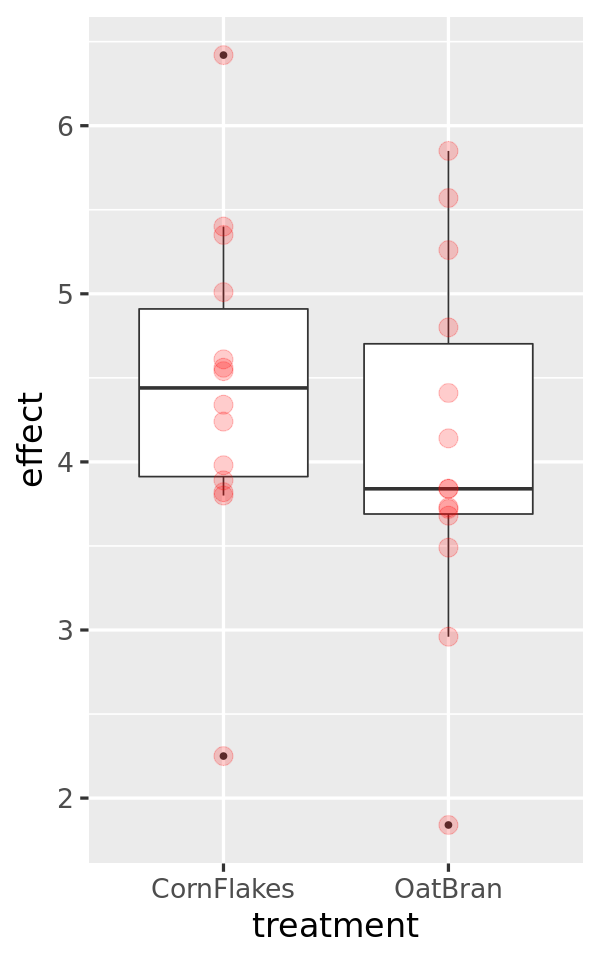

In [2]:
# set plot dimensions
options(repr.plot.width=5, repr.plot.height=8)

data_grouped %>% 
  ggplot(aes(x=treatment, y=effect)) + 
  geom_boxplot() +
  geom_point(color="red", size=5, alpha=0.2) + 
  theme_grey(base_size = 20)               

---
## How can we quantify the differences between the groups in a standardized way?

We can standardize the differences by dividing the difference of means between the groups with the standard error of means (SEM) in both groups. This is also known as a _t-statistic_

$$
t = \frac{\text{Difference of means between group 1 and 2}}{\text{Standard error of means (SEM) in both groups}}
$$

$$
t = \frac{\bar{x}_1 -\bar{x}_2 }{\sqrt{s_1^2/n_1 + s_2^2/n_2}}
$$




In [3]:
head(data)

CornFlakes,OatBran
<dbl>,<dbl>
4.61,3.84
6.42,5.57
5.40,5.85
4.54,4.80
3.98,3.68
3.82,2.96


In [4]:
data %>% 
summarize(diff_mean = mean(OatBran)-mean(CornFlakes),
          se1 = sd(CornFlakes)^2/n(),
          se2 = sd(OatBran)^2/n(),
           se = sqrt(se1 + se2),
            t = abs(diff_mean)/se)

diff_mean,se1,se2,se,t
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.3628571,0.06704572,0.07980051,0.3832052,0.9469003


**Using a function**

We can also use the ```t_test``` function from the ```rstatix``` library
- `dependent variable` ~ `independent variable` to specify effect and treatment
- `paired = FALSE` for independent samples

In [5]:
obs_stat <- data_grouped %>% 
            rstatix::t_test(effect ~ treatment, paired=FALSE) %>%
            pull(statistic)
obs_stat

t 
0.9469003

---
## 1. Resampling approach

To get an intuition of the null hypothesis test, we can use the resampling approach
- To do this, we randomly mix the  values between the 2 groups and do this multiple times to generate a _dataset that represents the null hypothesis_
- We then calculate the differences between the 2 groups generated by random mixing of the groups using the t-statistic to generate the null distribution of values
- Finally, we calculate the _p-value_, which is the probability we  find a standardized difference that is equal/greater than the  observed t-statistic assuming that there is no difference (null dataset)

$$P(\text{Data}|\text{Null distribution})$$

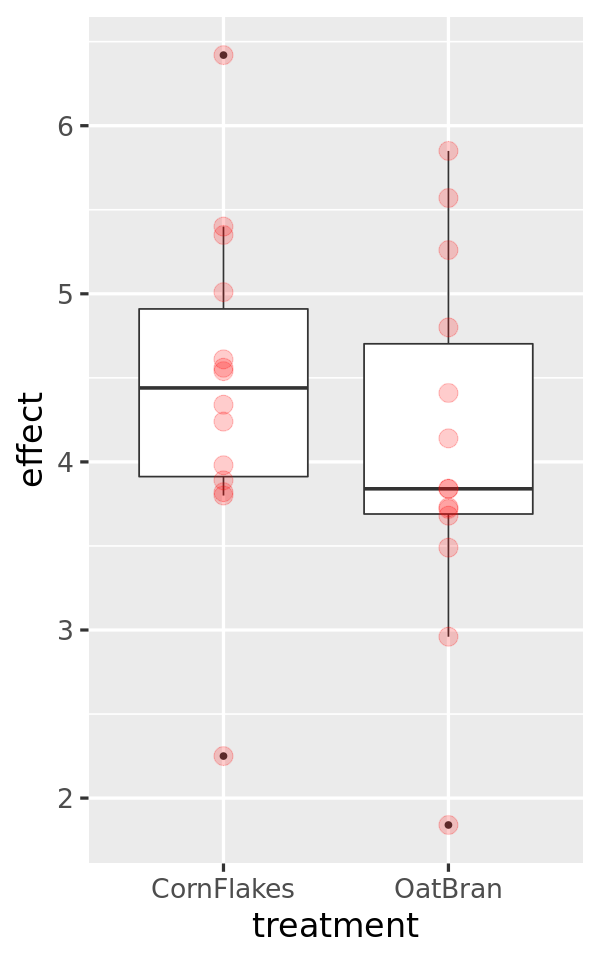

In [6]:
# set plot dimensions
options(repr.plot.width=5, repr.plot.height=8)

data_grouped %>% 
ggplot(aes(x=treatment, y=effect)) + 
  geom_boxplot() +
  geom_point(color="red", size=5, alpha=0.2) + 
  theme_grey(base_size = 20)          

### 1.1. Generate a null hypothesis dataset by resampling
First, we will generate 1000 samples from the data that are randomized between the 2 diet groups using the `infer` library

In [7]:
library(infer)

num_resample <- 1000

# permute samples

permute <- data_grouped %>%
           specify(effect ~ treatment) %>%
           hypothesize(null="independence") %>%
           generate(reps=num_resample, type="permute")

# taking a look

head(permute)
tail(permute)

effect,treatment,replicate
<dbl>,<fct>,<int>
5.85,CornFlakes,1
3.80,CornFlakes,1
4.24,CornFlakes,1
4.14,CornFlakes,1
4.56,CornFlakes,1
3.84,CornFlakes,1


effect,treatment,replicate
<dbl>,<fct>,<int>
3.68,OatBran,1000
3.89,OatBran,1000
4.34,OatBran,1000
2.96,OatBran,1000
6.42,OatBran,1000
3.84,OatBran,1000


We can plot samples from the permuted dataset

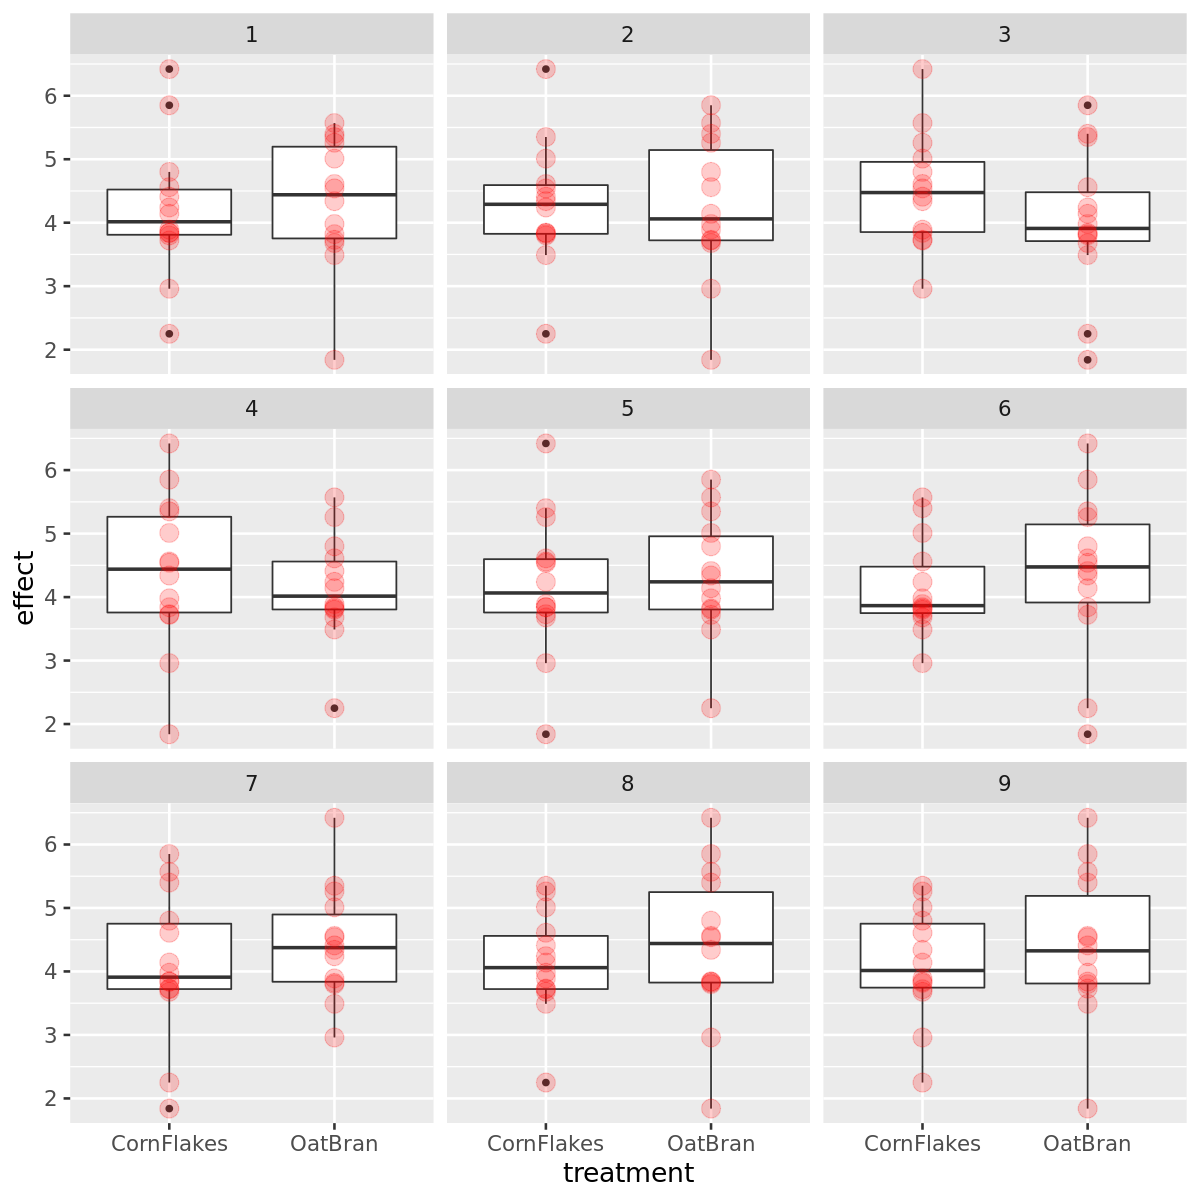

In [8]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

permute %>% 
filter(replicate <= 9) %>%                 # select first 9 replicates
ggplot(aes(x = treatment, y = effect)) +   # do boxplots
  geom_boxplot() +
  geom_point(color="red", size=5, alpha=0.2) +
  facet_wrap(~replicate) +
  theme_grey(base_size=16)

### 1.2. Calculate the test statistic for each replicate in the null dataset to obtain the null distribution

Next, we calculate the t-statistic for each of the 1000 replicate samples using the `t_test` function from the `rstatix` library

In [9]:
# calculate t statistic for each set of replicates

resample <- permute %>% 
            group_by(replicate) %>%
            rstatix::t_test(effect~treatment) %>% # t-test calculation
            rename(stat=statistic) %>%
            select(replicate, stat)

head(resample)
tail(resample)

replicate,stat
<int>,<dbl>
1,-0.3490173
2,0.1063165
3,1.2972424
4,0.6916867
5,-0.3158190
6,-0.6278044


replicate,stat
<int>,<dbl>
995,-0.8014217
996,-0.1026489
997,0.2716160
998,-1.1024964
999,0.8204479
1000,-1.3741740


### 1.3. Use the null distribution to calculate the p-value

We can check the t-statistic from each replicate from the null dataset to see if the value is **equal to or exceeds** the observed t-statistic `obs_stat`

In [10]:
resample <- resample %>% 
            mutate(exceed = if_else(abs(stat) >= abs(obs_stat), "Y","N") %>%
                            factor(levels=c("Y","N")))

head(resample)
tail(resample)

replicate,stat,exceed
<int>,<dbl>,<fct>
1,-0.3490173,N
2,0.1063165,N
3,1.2972424,Y
4,0.6916867,N
5,-0.3158190,N
6,-0.6278044,N


replicate,stat,exceed
<int>,<dbl>,<fct>
995,-0.8014217,N
996,-0.1026489,N
997,0.2716160,N
998,-1.1024964,Y
999,0.8204479,N
1000,-1.3741740,Y


We can visualize the distribution of t-statistic values and indicate those values that are equal or exceed the the observed t-statistic

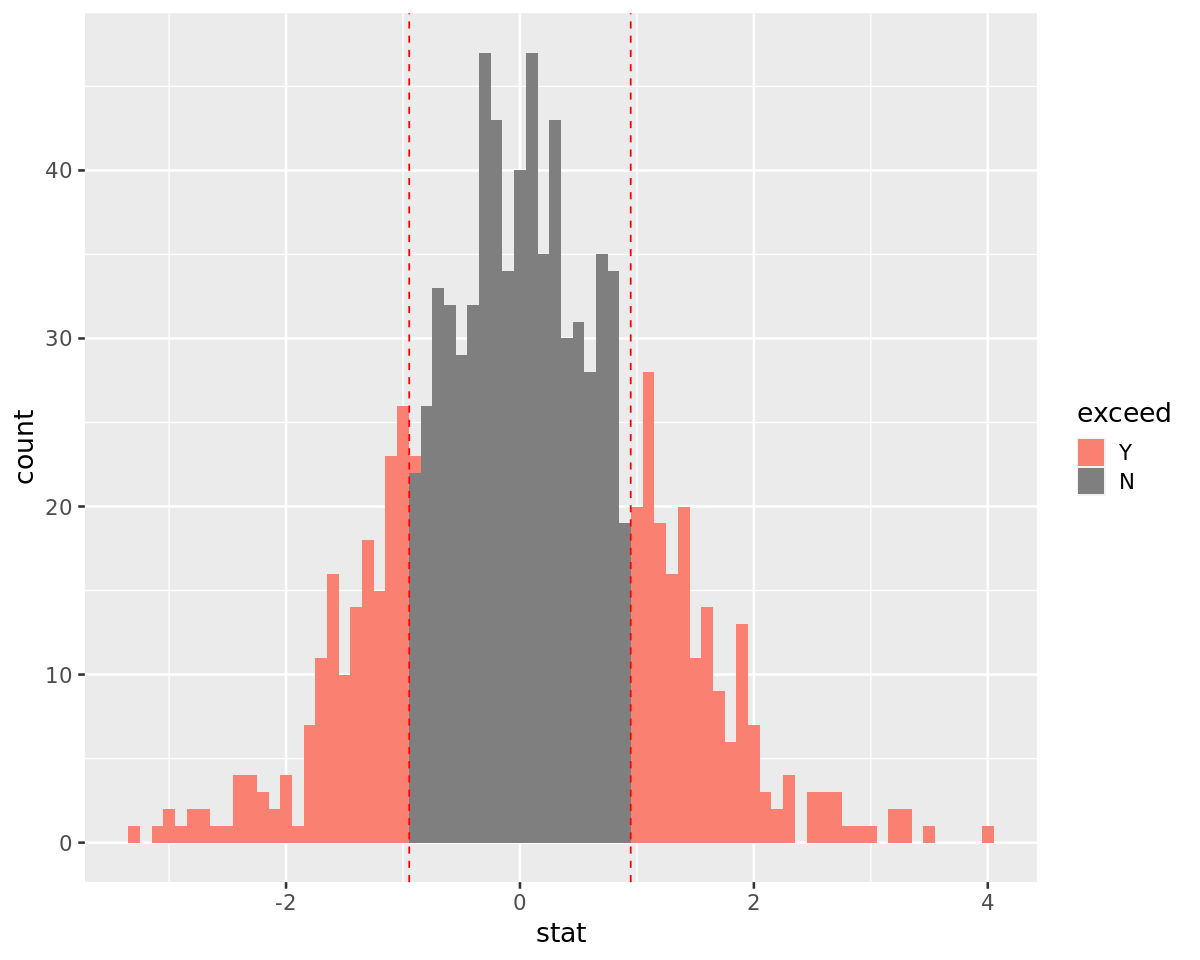

In [11]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=8)

resample %>% 
ggplot(aes(x=stat, fill=exceed)) + 
  geom_histogram(binwidth=0.1) + 
  geom_vline(xintercept = obs_stat, color="red", linetype="dashed") +
  geom_vline(xintercept = -obs_stat, color="red", linetype="dashed") +
  scale_fill_manual(values=c("salmon", "grey50"), 
                    labels=c("Y","N"), drop=FALSE) +
  theme(legend.position = "top") +
  theme_grey(base_size=16)

Finally, we can get the _p-value_ by calculating how many times the t-statistic in the null distribution is equal/exceeds the observed t-statistic

In [12]:
resample %>% summarize(num_resample = n(),
                       num_exceed = if_else(exceed == "Y", 1,0) %>% sum,
                       p_value = num_exceed/num_resample)

num_resample,num_exceed,p_value
<int>,<dbl>,<dbl>
1000,360,0.36


We can see that in null distribution, ~30-40% of the values are equal or exceed the observed t-statistic calculated from the dataset. It implies that these differences in the dataset may possibly be due to random chance

---
## 2. Analytical approach (unpaired t-test)

In the analytical approach, the null distribution is not derived from resampling, but it is calculated from a theoretical formula that generalizes the distribution

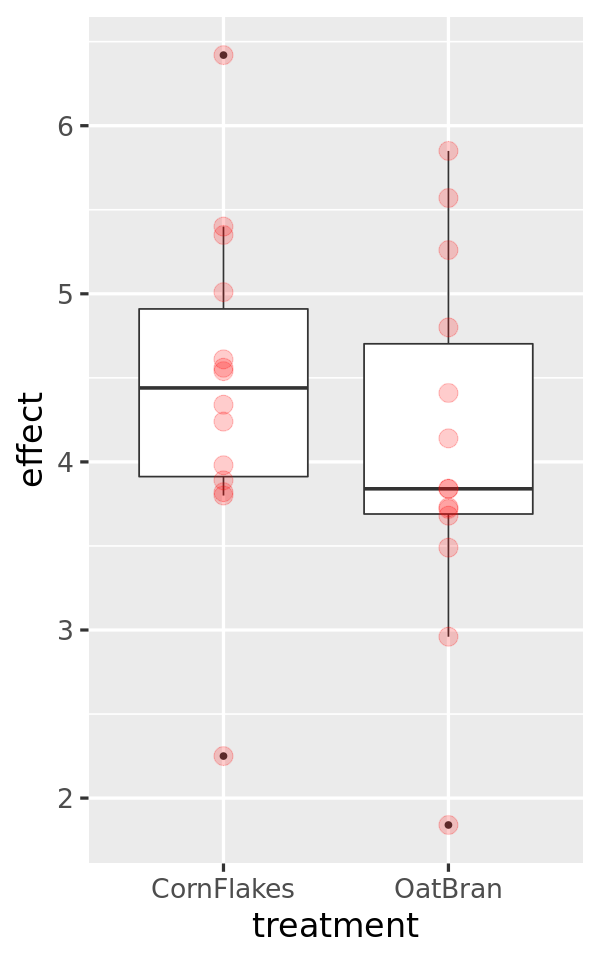

In [13]:
# set plot dimensions
options(repr.plot.width=5, repr.plot.height=8)

data_grouped %>% 
ggplot(aes(x=treatment, y=effect)) + 
  geom_boxplot() +
  geom_point(color="red", size=5, alpha=0.2) + 
  theme_grey(base_size = 20)         

### 2.1. Calculate the test statistic

We calculate the standardized t-score that quantifies the differences between the 2 groups. This score can be compared to a t-distribution, used as the null hypothesis distribution

In [14]:
obs_stat <- data_grouped %>% 
            rstatix::t_test(effect ~ treatment, paired=FALSE) %>%
            pull(statistic)
obs_stat

t 
0.9469003

### 2.2. Use the theoretical null distribution to calculate the p-value

The theoretical null t-distribution depends on the degrees of freedom parameter

![t-dist.png](images/t-dist.png)

- For each group of size ```n```, the degrees of freedom is ```n-1```
- For the total degrees of freedom in the dataset, we sum the degrees of freedom for each group i.e ```(n-1) + (n-1) = 2*(n-1)``` where ```n``` is the number samples in each group (equal)
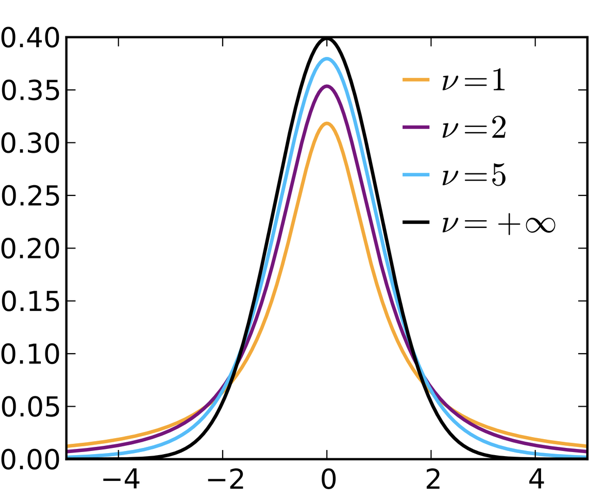

In [15]:
# get number of categories and number of samples
num_categories <- nlevels(data_grouped$treatment)
num_samples <- nrow(data_grouped)/num_categories

# calculate degrees of freedom for all the categories
df <- num_categories * (num_samples - 1)
df

[1] 26

We then plot the t-distribution with the calculated degrees of freedom using the ```vdist_t_prob``` from the ```vistributions``` library
- We specify the observed t-statistic ```obs_stat``` and calculate the probability that the t-statistic from the data will be observed in a null distribution

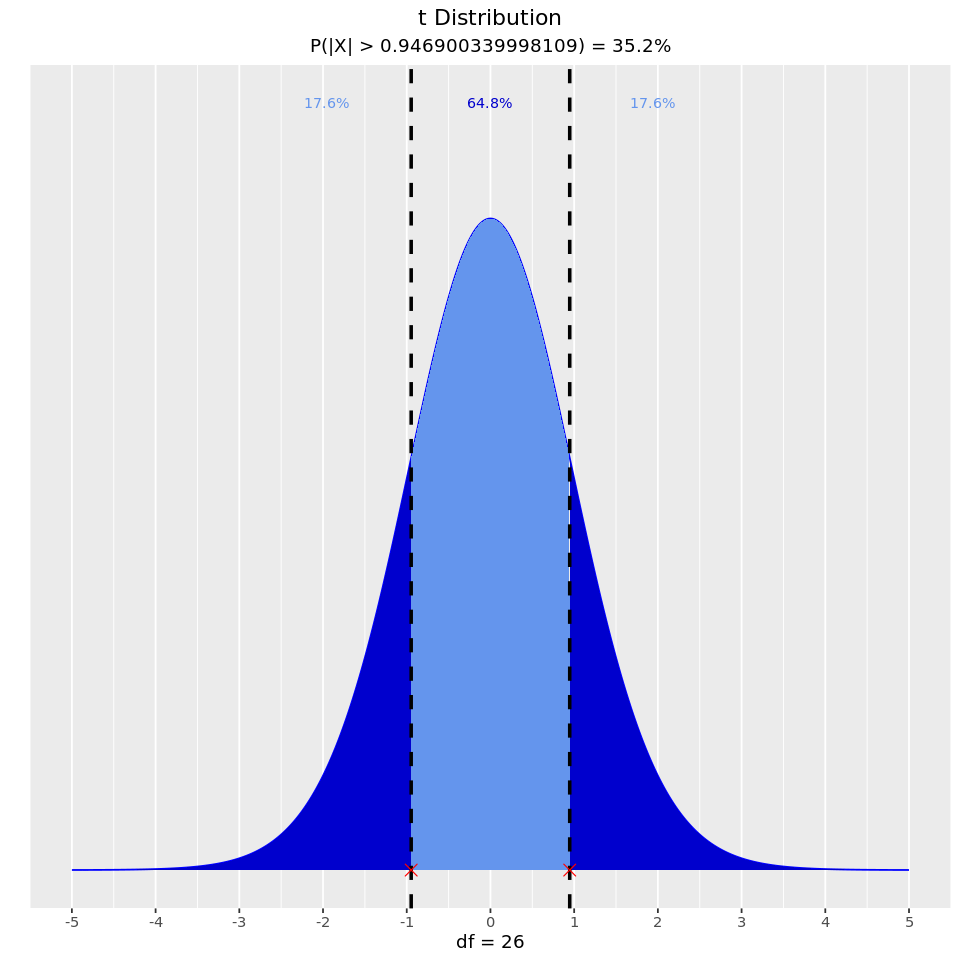

In [16]:
library(vistributions)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

vdist_t_prob(obs_stat, df = df, "both")

We find that in ~35% of the time (p = 0.35), the observed t-statistic will be found in the null distribution

- This is close to the estimate we got from the resampling approach
- By convention (p>0.05), there is no evidence against the null hypothesis suggesting that the differences observed could be due to random chance

**Using a function**

We get a similar result using the `t_test` function from the `rstatix` library
- `paired = FALSE` for unrelated (independent) subjects
- `detailed = TRUE` to obtain the 95% CI

In [17]:
data_grouped %>% 
rstatix::t_test(effect ~ treatment, 
                paired = FALSE,
                detailed = TRUE)

,estimate,estimate1,estimate2,.y.,group1,group2,n1,n2,statistic,p,df,conf.low,conf.high,method,alternative
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.3628571,4.443571,4.080714,effect,CornFlakes,OatBran,14,14,0.9469003,0.352,25.80532,-0.4251218,1.150836,T-test,two.sided


---
## 3. Rank-based approach (Mann-Whitney U-test)

The analytic approach based on theoretical distributions specified by parameters from the data assumes a normal distribution of the data

Consequently, this parametric approach may not work well under certain situations
- small and/or skewed data that are not normally distributed
- data that are ordinal in nature (e.g. pain score, ranking of food preferences)

We will use the same dataset to illustrate the **Mann-Whitney U-test** for independent samples
- Convert values to ranks
- Calculate the test statistic (U)
- Calculate the p-value based on the null distribution

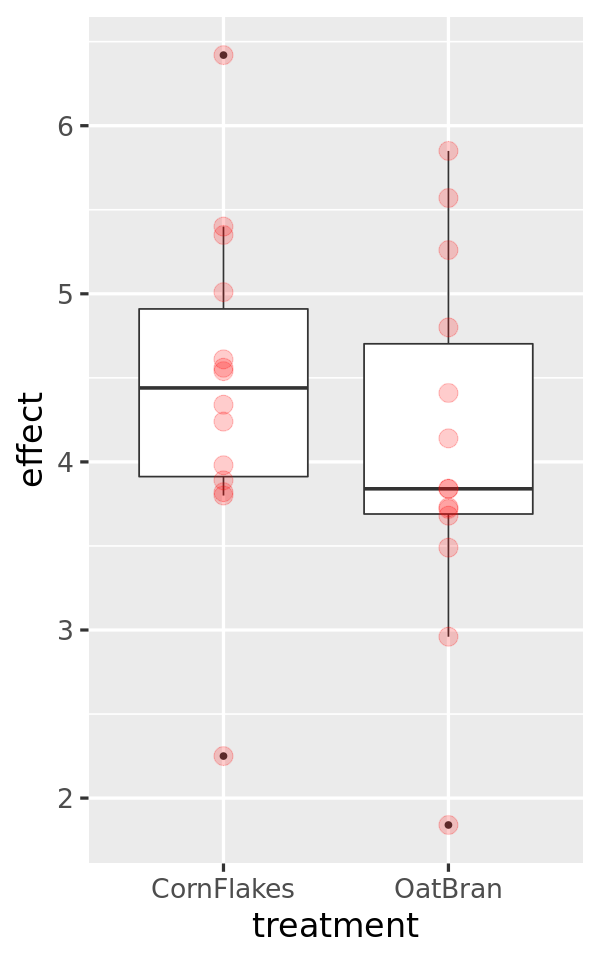

In [18]:
# set plot dimensions
options(repr.plot.width=5, repr.plot.height=8)

data_grouped %>% 
ggplot(aes(x=treatment, y=effect)) + 
  geom_boxplot() +
  geom_point(color="red", size=5, alpha=0.2) + 
  theme_grey(base_size = 20)

We can examine the QQ-plot to see if the values deviate from a normal distribution

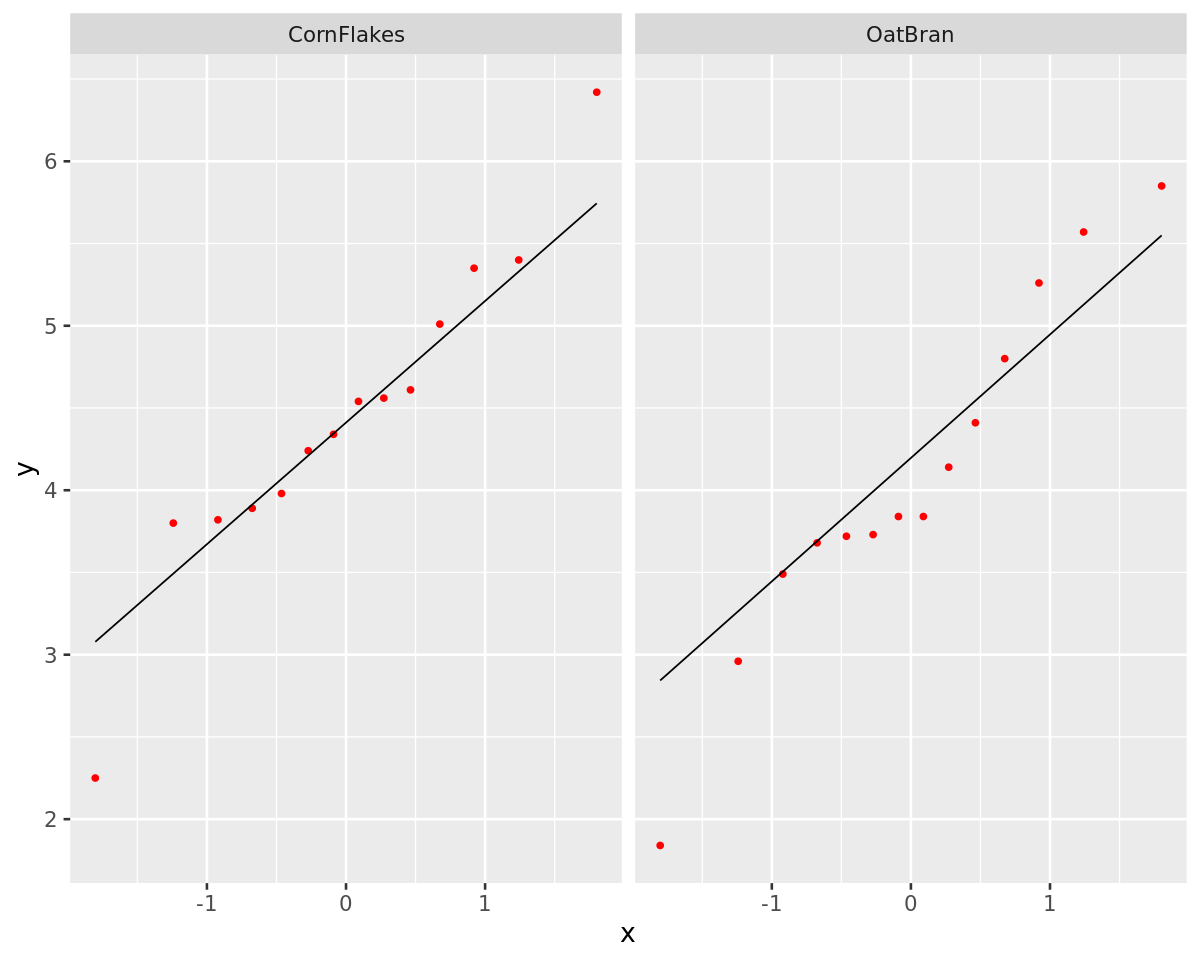

In [19]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=8)

data_grouped %>% 
ggplot(aes(sample=effect)) + 
  geom_qq(color="red") +
  geom_qq_line() +
  facet_grid(.~treatment) +
  theme_grey(base_size = 16)

In such cases, a rank-based approach can be used

### 3.1. Convert values to ranks

In [20]:
data_rank <- data_grouped %>% 
             arrange(effect) %>%
             mutate(rank=rank(effect))

data_rank %>% sample_n(10)

treatment,effect,rank
<fct>,<dbl>,<dbl>
OatBran,3.72,6.0
CornFlakes,4.24,15.0
OatBran,3.84,10.5
CornFlakes,4.61,20.0
OatBran,1.84,1.0
CornFlakes,5.01,22.0
CornFlakes,4.34,16.0
OatBran,4.80,21.0
CornFlakes,4.54,18.0


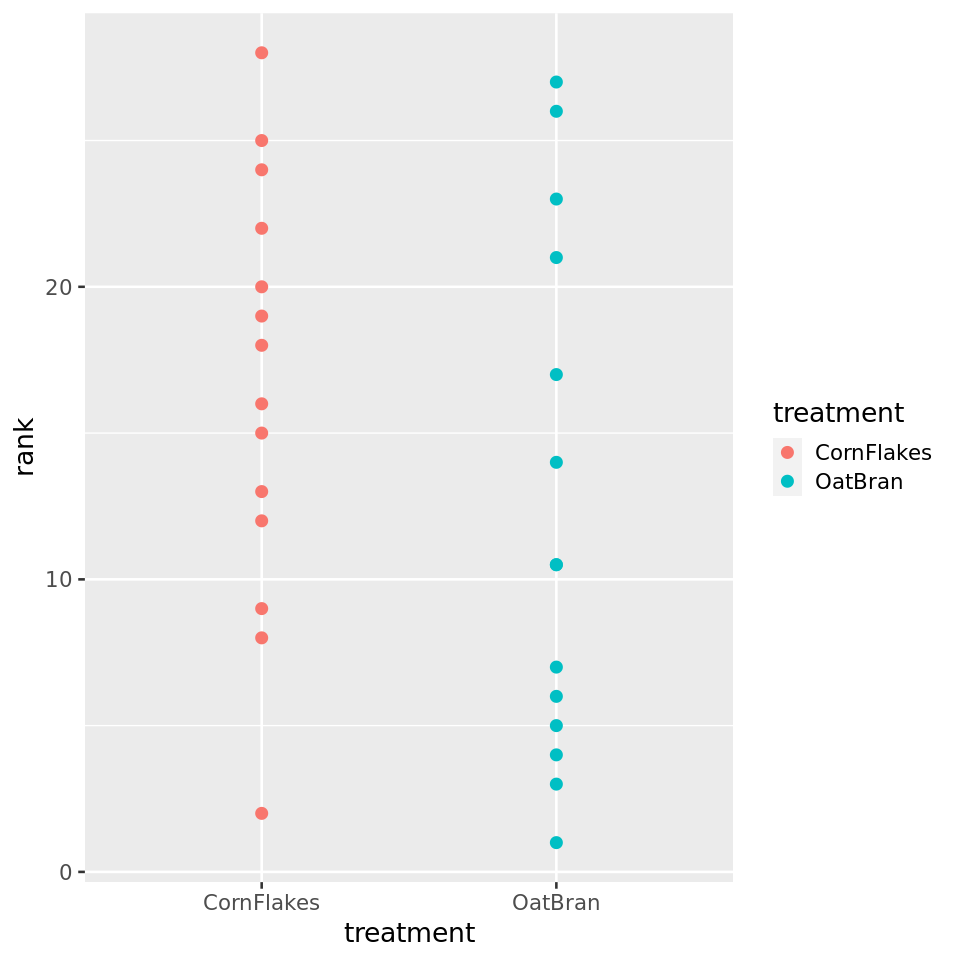

In [21]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_rank %>% 
ggplot(aes(x=treatment, y=rank, color=treatment)) +
  geom_point(size=3) +
  theme_grey(base_size=16)

### 3.2. Calculate the rank-based test statistic

We can calculate a U statistic to look for the differences in the ranks for both groups. 

$$ U_{1}=R_{1}-\frac{n_{1}\left(n_{1}+1\right)}{2} $$

$$ U_{2}=R_{2}-\frac{n_{2}\left(n_{2}+1\right)}{2} $$

where
- $R_1$ = sum of ranks for group 1
- $R_2$ = sum of ranks for group 2
- $n_1$ = number of samples in group 1
- $n_2$ = number of samples in group 2 

Recall that $ \frac{n\left(n+1\right)}{2} $ is the total for a series from 1 to $n$, so intuitively we are looking for the difference in the sum of ranks observed in each group and the the sum of ranks if there was no change in ranking in each group

In [22]:
data_rank_sum <- data_rank %>% 
                 group_by(treatment) %>%
                 summarize(rank_sum=sum(rank),
                           n=n(),
                           total_rank=n*(n+1)/2,
                           u=rank_sum-total_rank)
data_rank_sum

treatment,rank_sum,n,total_rank,u
<fct>,<dbl>,<int>,<dbl>,<dbl>
CornFlakes,231,14,105,126
OatBran,175,14,105,70


### 3.3. Use the null distribution of ranks to find the p-value

Now that we have a test statistic of the ranks, we will need to generate a null distribution to compare it to.

To get an intuition of the null distribution of ranks, we can simulate the null distribution of a U-statistic by permuting the different ranks in the groups and calculating the U-statistic for each replicate (10,000)
- Using this null distribution, we check if each value in the null distribution is equal to or exceeds the U-statistic that we observe in our data

In [23]:
sample_once <- function(n) {
    
    total_ranks <- n*(n+1)/2
    choose <- sum(sample(seq(1,n*2), n))-total_ranks
    return(choose)
}

resample <- tibble(replicate=1:10000,
            ranksum=as.numeric(replicate(10000,sample_once(14)), simplify=F)) %>%
            mutate(exceed=ifelse(ranksum<=70 | ranksum>=126,"Y","N") %>%
            factor(levels=c("Y","N")))

# taking a look

head(resample)
tail(resample)

replicate,ranksum,exceed
<int>,<dbl>,<fct>
1,98,N
2,115,N
3,77,N
4,136,Y
5,79,N
6,111,N


replicate,ranksum,exceed
<int>,<dbl>,<fct>
9995,123,N
9996,115,N
9997,103,N
9998,102,N
9999,100,N
10000,119,N


We can plot the null distribution and and see how often the observed U-statistic exceeds the values in the null distribution of ranks

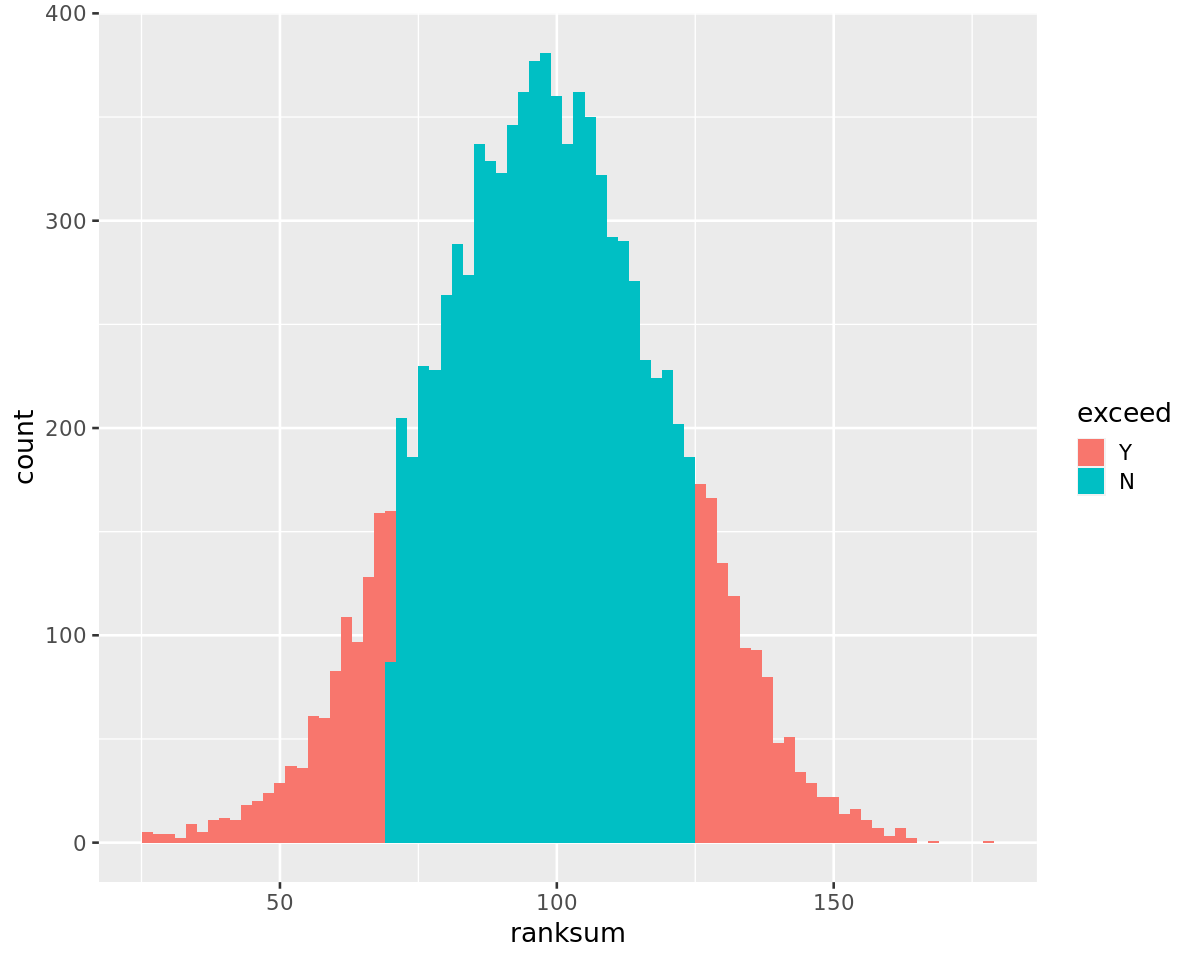

In [24]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=8)

resample %>% 
ggplot(aes(x=ranksum,fill=exceed)) + 
  geom_histogram(binwidth=2) +
  theme_grey(base_size=16)

In [25]:
resample %>% summarize(num_resample = n(),
                       num_exceed = if_else(exceed == "Y", 1,0) %>% sum,
                       p_value = num_exceed/num_resample)

num_resample,num_exceed,p_value
<int>,<dbl>,<dbl>
10000,2125,0.2125


We find that ~20% of the time, we can observe the U-statistic in the null distribution of values. This suggests that the observed differences in ranks may be due to random chance

Analytically, we can also use the **theoretical distribution**. In this case, for 2 independent groups of ranks, we use the Wilcoxon distribution and specify the number of ranks in the `dwilcox` function

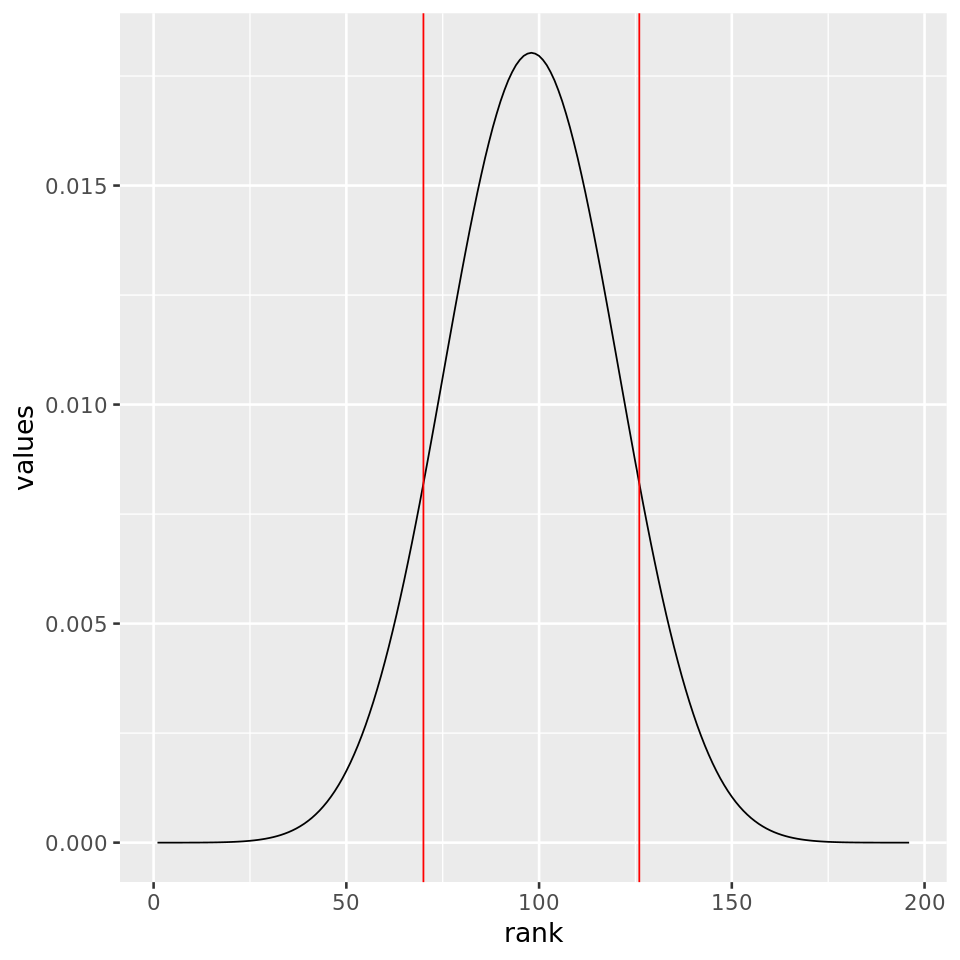

In [26]:
dist_wilcox <- data.frame(rank = seq(1,14*14),
                          values = dwilcox(seq(1,14*14),14,14))

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

dist_wilcox %>% 
ggplot(aes(x=rank, y=values)) +
  geom_line() +
  geom_vline(xintercept = 70, color="red") +
  geom_vline(xintercept = 126, color="red") +
  theme_grey(base_size=16)

We can use the `pwilcox` function to find the cumulative probability of the result being equal or more extreme than the observed test statistic assuming the null hypothesis: `pwilcox(q, m, n, lower.tail = T)` 
- `q` = observed test statistic
- `m` = number of observations in group 1
- `n` = number of observations in group 2

In [27]:
pwilcox(70,14,14, lower.tail = T) * 2 # symmetric (lower tail = upper tail)

[1] 0.2099778

**Using a function**

We can use the `wilcox_test` function from the `rstatix` library to calculate the p-value and specify `detailed=T` to obtain the 95% CI of the difference in `median`

In [28]:
data_grouped %>% 
rstatix::wilcox_test(effect ~ treatment, 
                     detailed=T)

,estimate,.y.,group1,group2,n1,n2,statistic,p,conf.low,conf.high,method,alternative
,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.3999671,effect,CornFlakes,OatBran,14,14,126,0.206,-0.3399688,1.049986,Wilcoxon,two.sided


---
## Effect size

### 1. Parametric

We can use the standardized effect size for independent samples

$$d = \frac{\text{Difference of means between group 1 and 2}}{\text{SD of means in both groups}}$$

In [29]:
head(data)

CornFlakes,OatBran
<dbl>,<dbl>
4.61,3.84
6.42,5.57
5.40,5.85
4.54,4.80
3.98,3.68
3.82,2.96


In [30]:
data %>% 
summarize(diff_mean = mean(CornFlakes)-mean(OatBran),
          var1 = var(CornFlakes),
          var2 = var(OatBran),
          pooled_sd = sqrt((var1+var2)/2),
          d = abs(diff_mean)/pooled_sd)

diff_mean,var1,var2,pooled_sd,d
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3628571,0.9386401,1.117207,1.013866,0.3578947


**Using a function**

We can use the `cohen_d` function from the library `rstatix`
- `paired = FALSE` for independent samples
- `ci = TRUE` for 95% CI

In [31]:
data_grouped %>% 
rstatix::cohens_d(effect ~ treatment, 
                  paired = FALSE,
                  ci = TRUE)

,.y.,group1,group2,effsize,n1,n2,conf.low,conf.high,magnitude
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<ord>
1,effect,CornFlakes,OatBran,0.3578947,14,14,-0.39,1.31,small


When the number of samples are small, a correction factor `hedges.correction = TRUE` can be specified so that the effect size is not overestimated. This corrected standardized effect size is known as _Hedge's g_

In [32]:
data_grouped %>% 
rstatix::cohens_d(effect ~ treatment, 
                  paired = FALSE, 
                  ci = TRUE,
                  hedges.correction = TRUE)

,.y.,group1,group2,effsize,n1,n2,conf.low,conf.high,magnitude
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<ord>
1,effect,CornFlakes,OatBran,0.3474706,14,14,-0.39,1.18,small


### 2. Rank-based

For quantifying the standardized effect size for ranks from independent samples, we calculate the rank biserial correlation

$$
R_{\mathit{biserial}}=\frac{2*(\mu_{rank1} - \mu_{rank2})}{\text{number of samples}}
$$


In [33]:
data_grouped_rank <- data_grouped %>% 
                     mutate(rank=rank(effect))

head(data_grouped_rank)
tail(data_grouped_rank)

treatment,effect,rank
<fct>,<dbl>,<dbl>
CornFlakes,4.61,20
CornFlakes,6.42,28
CornFlakes,5.40,25
CornFlakes,4.54,18
CornFlakes,3.98,13
CornFlakes,3.82,9


treatment,effect,rank
<fct>,<dbl>,<dbl>
OatBran,3.49,4.0
OatBran,3.84,10.5
OatBran,5.26,23.0
OatBran,3.73,7.0
OatBran,1.84,1.0
OatBran,4.14,14.0


In [34]:
data_grouped_rank %>% 
summarize(mean_rank1 = mean(rank[treatment=="CornFlakes"]),
          mean_rank2 = mean(rank[treatment=="OatBran"]),
          total_n = n(),
          rank_biserial = 2*(mean_rank1 - mean_rank2)/total_n)

mean_rank1,mean_rank2,total_n,rank_biserial
<dbl>,<dbl>,<int>,<dbl>
16.5,12.5,28,0.2857143


**Using a function**

We can calculate the rank biserial using the `rank_biserial` function from the `effectsize` library and specify the `paired = FALSE` option for independent samples

In [35]:
effectsize::rank_biserial(effect ~ treatment, 
                          data = data_grouped, 
                          paired = FALSE)

Registered S3 method overwritten by 'parameters':
  method                         from      
  format.parameters_distribution datawizard



r_rank_biserial,CI,CI_low,CI_high
<dbl>,<dbl>,<dbl>,<dbl>
0.2857143,0.95,-0.1404419,0.622553


To get an interpretation of the effect size, we can pass the value to the `interpret_r` function

In [36]:
effectsize::rank_biserial(effect ~ treatment, 
                          data = data_grouped, 
                          paired = FALSE) %>% 
pull(r_rank_biserial) %>% 
effectsize::interpret_r()

[1] "medium"
(Rules: funder2019)


---
# Application: Statistical plotting

We will use the `ggstatsplot` library, which is a versatile library for statistical plotting

![ggstatsplot.png](images/ggstatsplot.png)

For details see: https://indrajeetpatil.github.io/ggstatsplot/

In [ ]:
library(ggstatsplot)

In [ ]:
library(tidyverse)

data <- read_tsv("https://raw.githubusercontent.com/kennethban/dataset/main/oatbran.tsv")

data_grouped <- data %>% 
                gather(CornFlakes, OatBran, 
                       key="treatment", 
                       value="effect")

data_grouped <- data_grouped %>% 
                mutate(treatment = as.factor(treatment))

head(data_grouped)
tail(data_grouped)

## 1. Parametric plot (unpaired t-test)

We will make a plot comparing the 2 independent groups with the parametric t-test using the `ggbetweenstats` function from `ggstatsplot`
- `x`: grouping variable
- `y`: measure variable
- `type`: default is `parametric`

For details, see: https://indrajeetpatil.github.io/ggstatsplot/reference/ggbetweenstats.html

In [ ]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

data_grouped %>% 
ggbetweenstats(x = treatment,
               y = effect) +
  theme_classic(base_size = 20)

## 2. Non-parametric plot (Mann-Whitney U-test)

We will make a plot comparing the 2 independent groups with the non-parametric Mann-Whitney U-test using the `ggbetweenstats` function from `ggstatsplot`
- `x`: grouping variable
- `y`: measure variable
- `type = "nonparametric"`

For details, see: https://indrajeetpatil.github.io/ggstatsplot/reference/ggbetweenstats.html

In [ ]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

data_grouped %>% 
ggbetweenstats(x = treatment,
               y = effect,
               type = "nonparametric") +
  theme_classic(base_size = 20)

---
## Exercise - Comparing measures 2 independent groups

For this exercise, we will use the Framingham heart dataset

In [ ]:
library(tidyverse)

# load data
data_plot <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# recap of what was done
data_plot <- data_plot %>% 
             rename(sex = male) %>%
             mutate(sex = as.factor(sex),
                    age = as.integer(age),
                    education = as.factor(education),
                    currentSmoker = as.factor(currentSmoker),
                    cigsPerDay = as.integer(cigsPerDay),
                    BPMeds = as.factor(BPMeds),
                    prevalentStroke = as.factor(prevalentStroke),
                    prevalentHyp = as.factor(prevalentHyp),
                    diabetes = as.factor(diabetes),
                    totChol = as.integer(totChol),
                    heartRate = as.integer(heartRate),
                    TenYearCHD = as.factor(TenYearCHD)
                    )

data_plot <- data_plot %>% 
             mutate(glucose = round(glucose/18, digits=1)) %>% # mg/dL to mmol/L
             mutate(totChol = round(totChol/39, digits=1))     # mg/dL to mmol/L

head(data_plot)

### Part 1

Plot the distributions of total cholesterol (`totChol`) for the patients with/without chronic heart disease (`TenYearCHD`) using `ggplot` from `tidyverse`

In [ ]:
library(tidyverse)

# start here

In [ ]:
# solution

# set plot dimensions
options(repr.plot.width=10, repr.plot.height=5)

data_plot %>% ggplot(aes(x=totChol, fill=TenYearCHD)) + 
                geom_histogram(binwidth=0.5) + 
                facet_grid(.~TenYearCHD) +
                theme_grey(base_size=16)

### Part 2

Generate a statistical plot comparing the total cholesterol `(totChol)` levels of patients with/without chronic heart disease `(TenYearCHD)` using `ggbetweenstats` from `ggstatsplot`
- Explain your choice of test
- State the summary statistic (mean or median) of each group
- State the effect size, 95% CI and p-value

In [ ]:
library(ggstatsplot)

# start here

In [ ]:
# solution

# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

data_plot %>% ggbetweenstats(x=TenYearCHD, 
                             y=totChol
                             ) +
              theme_classic(base_size = 16)